In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

from pycbc import conversions
from pycbc import detector
from pycbc.inference import io,models

In [3]:
def remove_space(df):
    df.columns = [c.replace(' ','') for c in df.columns]
    return df

def readlnb(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['lnB'].values[0] - d220['lnB'].values[0]

def readsnr(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['Estimated_SNR'].values[0], d220['Estimated_SNR'].values[0]

def readlnz_signalnoise(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['lnZ_signal'].values[0], d221['lnZ_noise'].values[0], d220['lnZ_signal'].values[0], d220['lnZ_noise'].values[0]

In [4]:
def lnb(filename):
	f = h5py.File(filename,'r')
	return f.attrs['log_evidence'] 

def pycbc_snr(filename):
    fp = io.loadfile(filename, 'r')
    # get the config, the data, and PSDs from the file
    # the config file:
    cp = fp.read_config_file()
    # the data
    data = fp.read_data()
    # the psds
    psds = fp.read_psds()
    model = models.read_from_config(cp, data=data, psds=psds)
    samples = fp.read_samples(list(fp['samples'].keys()))
    maxlidx = samples['loglikelihood'].argmax()
    maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}
    model.update(**maxlparams)
    model.loglikelihood
    return (2*model.loglr)**0.5

fixpsd = '/work/yifan.wang/ringdown/GW150914/pyring/r5-fixpsd-increase-flow/'
unfixpsd = '/work/yifan.wang/ringdown/GW150914/pyring/r6-dontfixpsd/'

def print_lnb_snr(path):
    dt = np.linspace(-1.46, 1.47, 13)
    t0 = 1126259462.4085495
    t = t0+dt/1000
    result = {}
    snr221 = {}
    snr220 = {}
    for i in range(13):
        print(i)
        f220 = path+'t'+str(i)+'/220/result.hdf'
        f221 = path+'t'+str(i)+'/221/result.hdf'
        try:
            result[t[i]] = lnb(f221) - lnb(f220)
        except FileNotFoundError:
            pass
        
        try:
            snr221[t[i]] = pycbc_snr(f221)
        except IOError:
            pass
        
        try:
            snr220[t[i]] = pycbc_snr(f220)
        except IOError:
            pass
    return result,snr221,snr220

In [5]:
pycbc_unfixpsd_lnb,pycbc_unfixpsd_snr221,pycbc_unfixpsd_snr220 = print_lnb_snr(unfixpsd)

0


1
2


3


4


5


6


7


8


9
10


11


12


In [6]:
pycbc_unfixpsd_lnb

{1126259462.4070895: 30.36299121833872,
 1126259462.4080663: 5.273569740762468,
 1126259462.4083104: 6.3016584911965765,
 1126259462.4087987: 4.254121150297578,
 1126259462.4090428: 2.18725428316975,
 1126259462.409531: 5.3286690092645586,
 1126259462.4097755: 6.425240658281837,
 1126259462.4100196: 4.91135007381672}

In [22]:
x,y = zip(*pycbc_unfixpsd_lnb.items())

In [23]:
x

(1126259462.4070895,
 1126259462.4080663,
 1126259462.4083104,
 1126259462.4087987,
 1126259462.4090428,
 1126259462.409531,
 1126259462.4097755,
 1126259462.4100196)

In [24]:
y

(30.36299121833872,
 5.273569740762468,
 6.3016584911965765,
 4.254121150297578,
 2.18725428316975,
 5.3286690092645586,
 6.425240658281837,
 4.91135007381672)

In [25]:
Det = detector.Detector('H1')
th1 = [x0+ Det.time_delay_from_earth_center(1.95,-1.27,x0)-1126259462.42323 for x0 in x]

In [26]:
th1

[-0.001455068588256836,
 -0.0004782676696777344,
 -0.00023412704467773438,
 0.0002541542053222656,
 0.0004982948303222656,
 0.0009865760803222656,
 0.0012309551239013672,
 0.0014750957489013672]

In [28]:
np.savetxt('./../figs/pycbc_results.txt',np.transpose([th1,y]))

In [39]:
pycbc_fixpsd_lnb,pycbc_fixpsd_snr221,pycbc_fixpsd_snr220 = print_lnb_snr(fixpsd)

0


1


2


3


4


5


6


7


8


9


10


11


12


# Reproducing PyRing Results

In [38]:
rootpath = '/work/yifan.wang/ringdown/GW150914/pyring/reproduce/'
time = np.linspace(-1.46,1.47,13)
pyring_lnb = {}
pyring_snr221 = {}
pyring_snr220 = {}

for i,t in enumerate(time):
    path = rootpath + '/t'+str(i)
    pyring_lnb[i] = readlnb(path)
    pyring_snr221[i],pyring_snr220[i] = readsnr(path)

Text(0.5, 1.0, 'Bayesian Evidence of 221 vs 220')

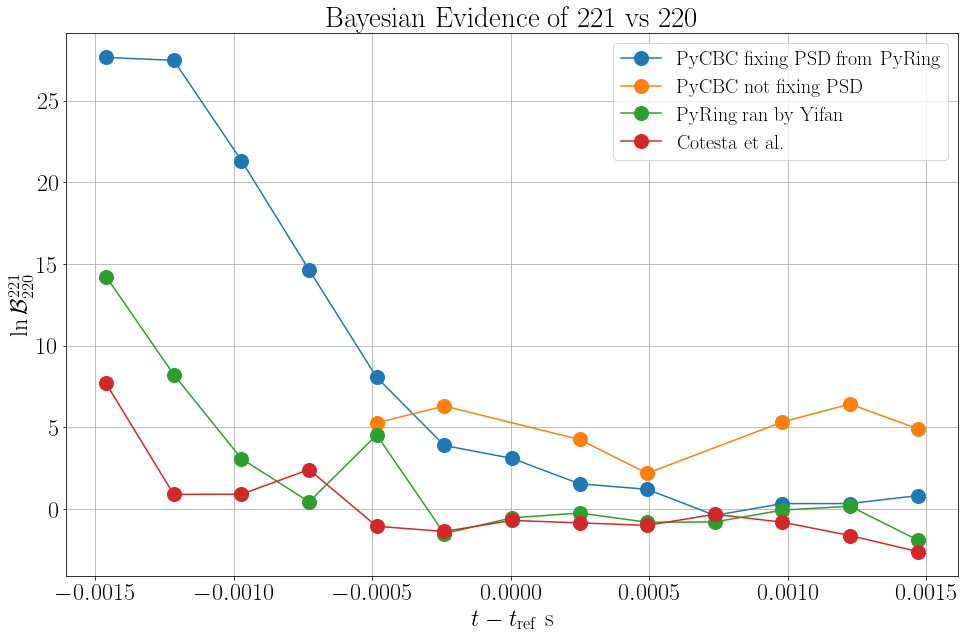

In [68]:
plt.figure(figsize=[16,10])
x,y = zip(*pycbc_fixpsd_lnb.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC fixing PSD from PyRing')
x,y = zip(*pycbc_unfixpsd_lnb.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC not fixing PSD')

dt = np.linspace(-1.46, 1.47, 13)
t0 = 1126259462.4085495
t = t0+dt/1000
_,y = zip(*pyring_lnb.items())
plt.plot(t-t0,y,marker='o',label='PyRing ran by Yifan')


filec = np.loadtxt('../data.txt')
plt.plot(t-t0,np.log(filec[:,1]),marker='o',label='Cotesta et al.')
#plt.axvline(1126259462.4085495,ls='--',label='t0')
plt.legend()
plt.ylabel('$\ln \mathcal{B}^{221}_{220}$')
plt.xlabel('$t-t_\mathrm{ref}$ s')
plt.title('Bayesian Evidence of 221 vs 220')

# 221 SNR

Text(0.5, 0, '$t-t_\\mathrm{ref}$ s')

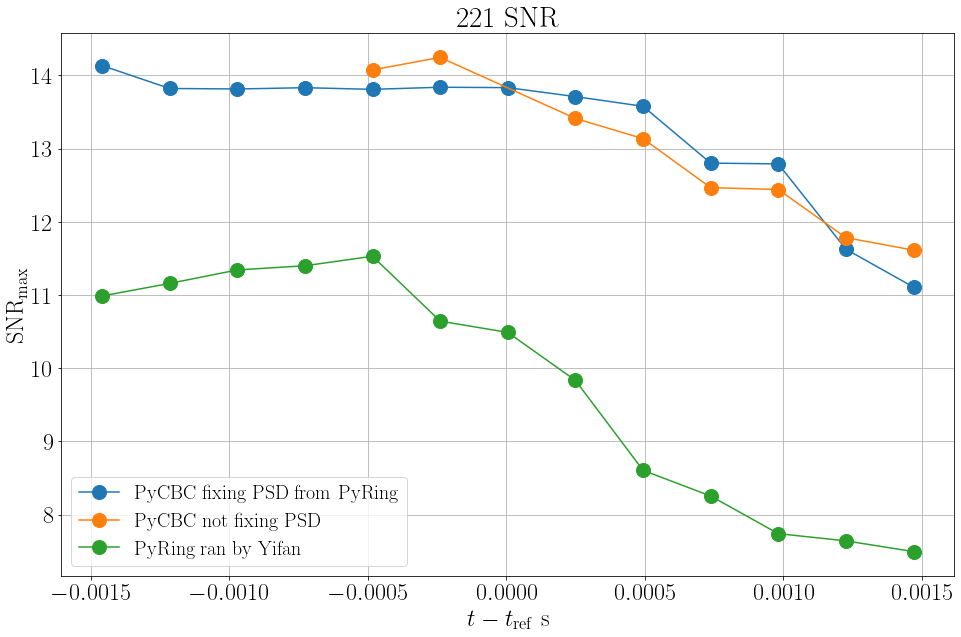

In [66]:
plt.figure(figsize=[16,10])
x,y = zip(*pycbc_fixpsd_snr221.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC fixing PSD from PyRing')
x,y = zip(*pycbc_unfixpsd_snr221.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC not fixing PSD')

dt = np.linspace(-1.46, 1.47, 13)
t0 = 1126259462.4085495
t = t0+dt/1000
_,y = zip(*pyring_snr221.items())
plt.plot(t-t0,y,marker='o',label='PyRing ran by Yifan')


#filec = np.loadtxt('../data.txt')
#plt.plot(t,np.log(filec[:,1]),marker='o',label='Cotesta et al.')
plt.title('221 SNR')
#plt.axvline(1126259462.4085495,ls='--',label='t0')
plt.legend()
plt.ylabel('SNR$_\mathrm{max}$')
plt.xlabel('$t-t_\mathrm{ref}$ s')

Text(0.5, 0, '$t-t_\\mathrm{ref}$ s')

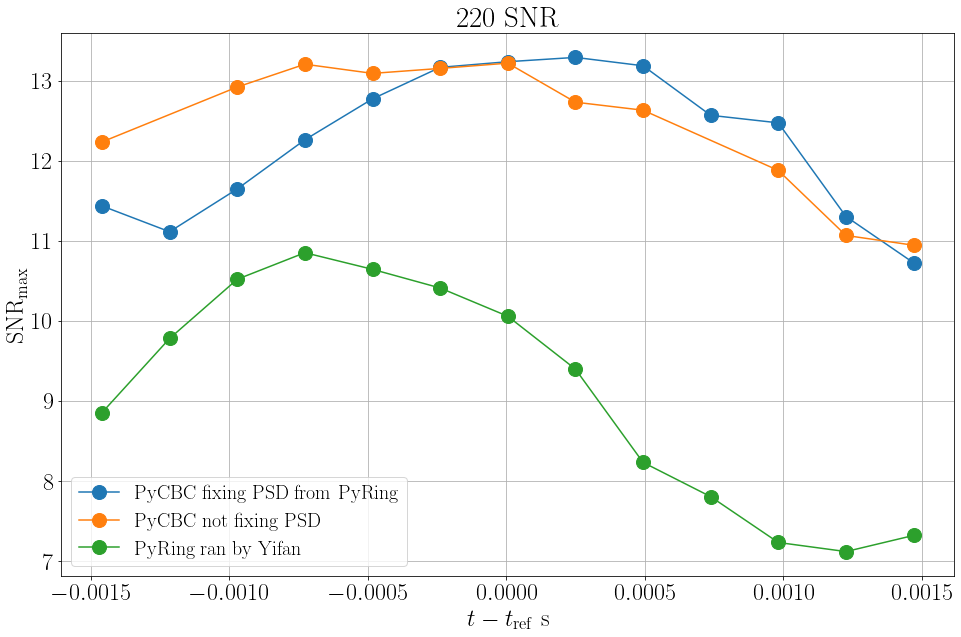

In [64]:
plt.figure(figsize=[16,10])
x,y = zip(*pycbc_fixpsd_snr220.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC fixing PSD from PyRing')
x,y = zip(*pycbc_unfixpsd_snr220.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC not fixing PSD')

dt = np.linspace(-1.46, 1.47, 13)
t0 = 1126259462.4085495
t = t0+dt/1000
_,y = zip(*pyring_snr220.items())
plt.plot(t-t0,y,marker='o',label='PyRing ran by Yifan')


#filec = np.loadtxt('../data.txt')
#plt.plot(t,np.log(filec[:,1]),marker='o',label='Cotesta et al.')
plt.title('220 SNR')
#plt.axvline(1126259462.4085495,ls='--',color='grey',label='t_{ref}')
plt.legend()
plt.ylabel('SNR$_\mathrm{max}$')
plt.xlabel('$t-t_\mathrm{ref}$ s')

Text(0.5, 0, '$t-t_\\mathrm{ref}$ s')

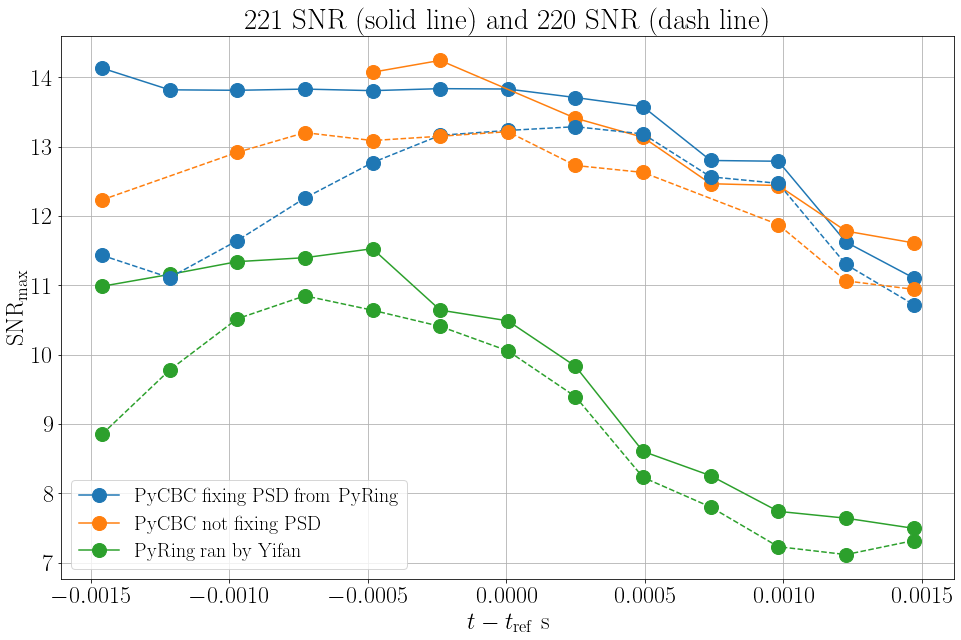

In [65]:
dt = np.linspace(-1.46, 1.47, 13)
t0 = 1126259462.4085495
t = t0+dt/1000

plt.figure(figsize=[16,10])
x,y = zip(*pycbc_fixpsd_snr221.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC fixing PSD from PyRing')
x,y = zip(*pycbc_unfixpsd_snr221.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',label='PyCBC not fixing PSD')


_,y = zip(*pyring_snr221.items())
plt.plot(t-t0,y,marker='o',label='PyRing ran by Yifan')

############220 SNR####################################
x,y = zip(*pycbc_fixpsd_snr220.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',ls='--',color='tab:blue')
x,y = zip(*pycbc_unfixpsd_snr220.items())
x = np.array(x)
plt.plot(x-t0,y,marker='o',ls='--',color='tab:orange')
_,y = zip(*pyring_snr220.items())
plt.plot(t-t0,y,marker='o',ls='--',color='tab:green')


#filec = np.loadtxt('../data.txt')
#plt.plot(t,np.log(filec[:,1]),marker='o',label='Cotesta et al.')
plt.title('221 SNR (solid line) and 220 SNR (dash line)')
#plt.axvline(1126259462.4085495,ls='--',color='grey',label='t0')
plt.legend()
plt.ylabel('SNR$_\mathrm{max}$')
plt.xlabel('$t-t_\mathrm{ref}$ s')